In [21]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, 
    TimeSeriesSplit, validation_curve
)
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier

from scipy import sparse

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
%config InlineBackend.figure_format = 'retina'

In [4]:
def get_summary_grid(grid):
    parms = list(grid.param_grid.keys())
    columns = ['Iter #']
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in grid.param_grid.keys():
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[1:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
    for k, v in grid.param_grid.items():
        items *= len(v)
    df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [5]:
def get_summary_randomized(grid):
    parms = list(grid.param_distributions.keys())
    columns = []
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in parms:
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[0:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
#     for k, v in grid.param_distributions.items():
#         items *= len(v)
#     df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

## Avg. W2V

### Loading the data

In [6]:
!ls ../Amazon_Review_commons

avgW2V_best.model  BOW_train.npz	  tfidf_train.npz
AvgW2V_test.csv    countVectorizer.model  tfidfVectorizer.model
AvgW2V_train.csv   Dtest.csv		  tfidfW2V_best.model
bog_best.model	   Dtrain.csv		  TFIDF_w2v_test.csv
bow_best.model	   tfidf_best.model	  TFIDF_w2v_train.csv
BOW_test.npz	   tfidf_test.npz


In [7]:
Drtain_avg_w2v = pd.read_csv('../Amazon_Review_commons/AvgW2V_train.csv')
Dtest_avg_w2v = pd.read_csv('../Amazon_Review_commons/AvgW2V_test.csv')

In [8]:
yTrain_avg_w2v = Drtain_avg_w2v.Label
yTest_avg_w2v = Dtest_avg_w2v.Label

Drtain_avg_w2v.drop(['Label'], inplace=True, axis=1)
Dtest_avg_w2v.drop(['Label'], inplace=True, axis=1)

### GridSearch 1

In [100]:
features = Drtain_avg_w2v
labels = yTrain_avg_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [101]:
estimator = DecisionTreeClassifier(random_state=42)

In [102]:
params = {
    'max_depth': [*range(2, 11)],
    'min_samples_split': [*range(2, 200, 10)]
}

In [103]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [ ]:
grid.fit(features, labels)

In [105]:
grid_res = get_summary_grid(grid)
grid_res.sort_values('test_f1', ascending=False).head()

,Iter #,train_recall,test_recall,train_precision,test_precision,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,score_time,max_depth,min_samples_split
139,140,0.979318,0.971873,0.896673,0.869018,0.883712,0.852966,0.936154,0.917550,5.498659,0.058938,8,192
138,139,0.979315,0.971840,0.896683,0.869014,0.883720,0.852938,0.936158,0.917533,5.330421,0.054354,8,182
137,138,0.979290,0.971667,0.896886,0.869046,0.883907,0.852834,0.936255,0.917471,5.496989,0.065979,8,172
136,137,0.979215,0.971496,0.897002,0.869158,0.883971,0.852830,0.936284,0.917456,5.495307,0.054385,8,162
135,136,0.979235,0.971460,0.897035,0.869152,0.884022,0.852801,0.936310,0.917438,5.204703,0.055039,8,152


In [107]:
grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=192,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### How F1 score changes as ```max_depth``` increases?

In [108]:
!ls

AVG_W2V_best.model	 grid_res2_tfidf_w2v.csv  TFIDF_W2V_best.model
Decision_Tree_W2V.ipynb  grid_res_avg_w2v.csv
grid_res2_avg_w2v.csv	 grid_res_tfidf_w2v.csv


In [111]:
sns.set_style("whitegrid")
grid_res.rename({'min_samples_split': 'min_samples'}, axis=1, inplace=True)

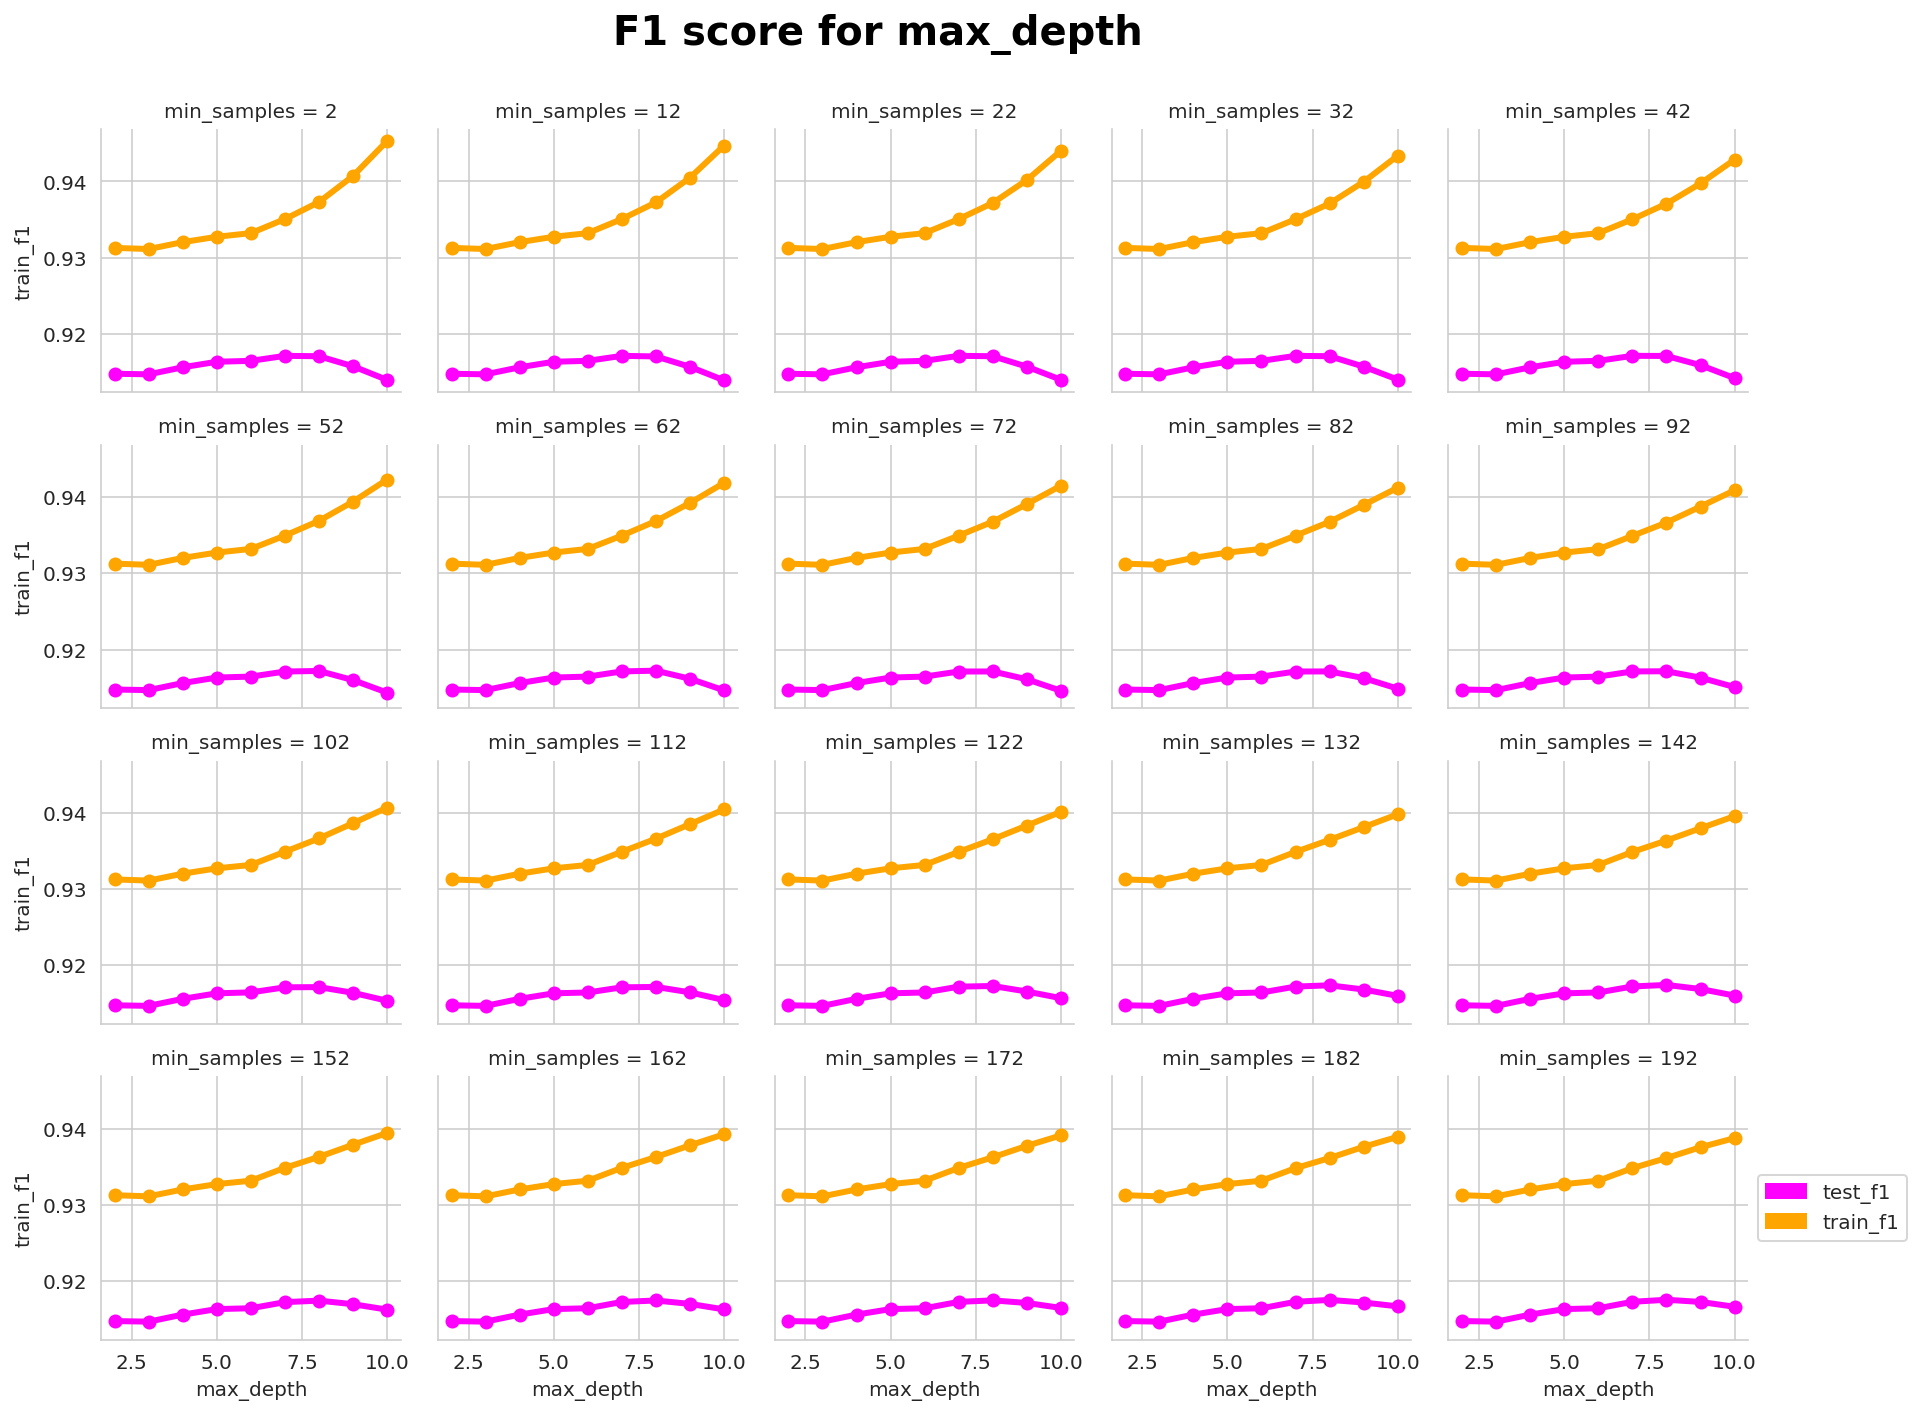

In [112]:
g = sns.FacetGrid(grid_res, col="min_samples", col_wrap=5, height=2.5)
g = g.map(plt.plot, "max_depth", "test_f1", marker="o", color='magenta', linewidth=3)
g = g.map(plt.plot, "max_depth", "train_f1", marker="o", color='orange', linewidth=3)
# legend_labels  = ['test_f1', 'train_f1']
# plt.legend(handles=legend_patches)
legend_patches = [matplotlib.patches.Patch(color='magenta', label='test_f1'),
                 matplotlib.patches.Patch(color='orange', label='train_f1')]
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1,0.5))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('F1 score for max_depth', size=20, weight='bold', color='black');

### GridSearch 2

In [113]:
estimator = grid.best_estimator_

In [114]:
params = {
    'min_samples_leaf': [*range(2, 11)],
    'splitter': ['random', 'best']
}

In [115]:
grid2 = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [ ]:
grid2.fit(features, labels)

In [117]:
grid_res2 = get_summary_grid(grid2)
grid_res2.sort_values('test_f1', ascending=False).head()

,Iter #,train_recall,test_recall,train_precision,test_precision,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,score_time,min_samples_leaf,splitter
17,18,0.979357,0.972231,0.896332,0.868941,0.883381,0.853145,0.935987,0.917668,5.234586,0.061199,10,best
15,16,0.979359,0.972215,0.896348,0.868947,0.883399,0.853140,0.935996,0.917664,5.584764,0.065413,9,best
11,12,0.979335,0.972149,0.896417,0.868992,0.883453,0.853140,0.936022,0.917659,5.853615,0.054025,7,best
13,14,0.979326,0.972182,0.896378,0.868957,0.883405,0.853126,0.935997,0.917655,5.859553,0.054653,8,best
9,10,0.979317,0.972116,0.896449,0.868988,0.883473,0.853112,0.936032,0.917642,5.970604,0.062825,6,best


In [118]:
grid2.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=192,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

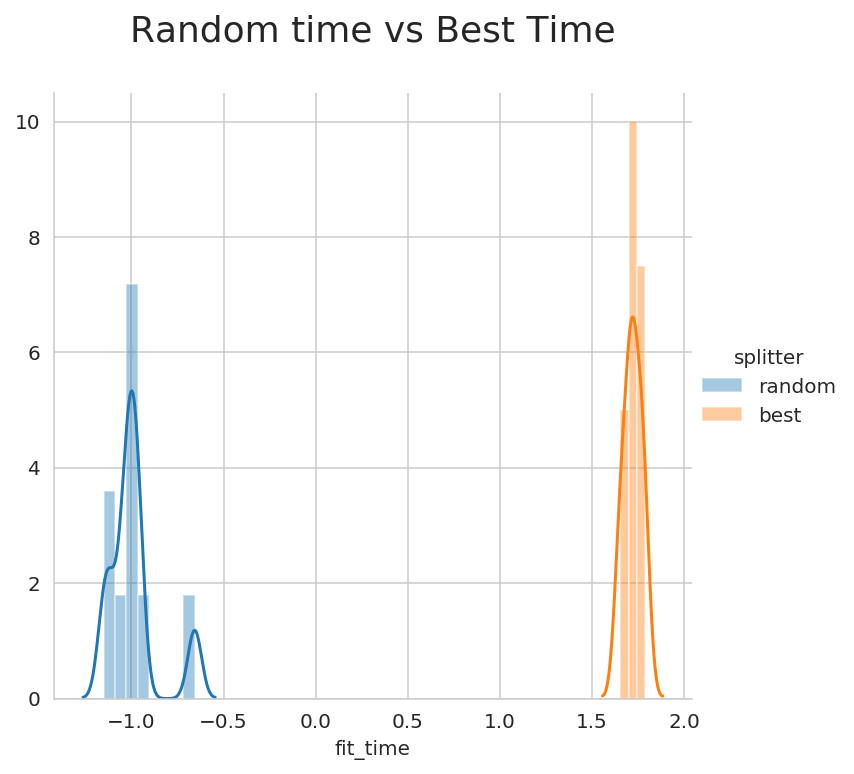

In [119]:
grid_res2['fit_time'] = np.log(grid_res2['fit_time'])
sns.FacetGrid(grid_res2, hue='splitter', height=5).map(sns.distplot, 'fit_time').add_legend();
plt.title('Random time vs Best Time\n', fontsize=18);

### Saving the best estimator

In [121]:
joblib.dump(grid2.best_estimator_, 'AVG_W2V_best.model')

['AVG_W2V_best.model']

## TFIDF. W2V

### Loading the data

In [122]:
!ls ../Amazon_Review_commons/*.csv

../Amazon_Review_commons/AvgW2V_test.csv
../Amazon_Review_commons/AvgW2V_train.csv
../Amazon_Review_commons/Dtest.csv
../Amazon_Review_commons/Dtrain.csv
../Amazon_Review_commons/TFIDF_w2v_test.csv
../Amazon_Review_commons/TFIDF_w2v_train.csv


In [9]:
Dtrain_tfidf_w2v = pd.read_csv('../Amazon_Review_commons/TFIDF_w2v_train.csv')
Dtest_tfidf_w2v = pd.read_csv('../Amazon_Review_commons/TFIDF_w2v_test.csv')

In [10]:
yTrain_tfidf_w2v = Dtrain_tfidf_w2v.Label
yTest_tfidf_w2v = Dtest_tfidf_w2v.Label

Dtrain_tfidf_w2v.drop(['Label'], inplace=True, axis=1)
Dtest_tfidf_w2v.drop(['Label'], inplace=True, axis=1)

### RandomizedSearch 1

In [125]:
features = Dtrain_tfidf_w2v
labels = yTrain_tfidf_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [126]:
estimator = DecisionTreeClassifier(random_state=42)

In [127]:
params = {
    'max_depth': [*range(2, 11)],
    'min_samples_split': [*range(2, 200, 10)]
}

In [128]:
grid = RandomizedSearchCV(estimator=estimator,
                    param_distributions=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    n_iter=150,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [ ]:
grid.fit(features, labels)

In [130]:
grid_res = get_summary_randomized(grid)
grid_res.sort_values('test_f1', ascending=False).head()

,train_recall,test_recall,train_precision,test_precision,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,score_time,max_depth,min_samples_split
113,0.9931,0.991009,0.879642,0.852109,0.875552,0.847406,0.932882,0.916243,11.519442,0.071708,5,132
141,0.9931,0.991009,0.879642,0.852109,0.875552,0.847406,0.932882,0.916243,12.007814,0.072690,5,192
128,0.9931,0.991009,0.879642,0.852109,0.875552,0.847406,0.932882,0.916243,11.380857,0.071539,5,22
66,0.9931,0.991009,0.879642,0.852109,0.875552,0.847406,0.932882,0.916243,11.698706,0.072116,5,42
54,0.9931,0.991009,0.879642,0.852109,0.875552,0.847406,0.932882,0.916243,11.875087,0.072199,5,52


In [131]:
grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=142,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### How F1 score changes as ```max_depth``` increases?

In [133]:
sns.set_style("whitegrid")
grid_res.rename({'min_samples_split': 'min_samples'}, axis=1, inplace=True)

In [134]:
## This is required because seabon facetgrid doesn't sort the x and y values
grid_res.sort_values(by=['max_depth', 'min_samples'], inplace=True)

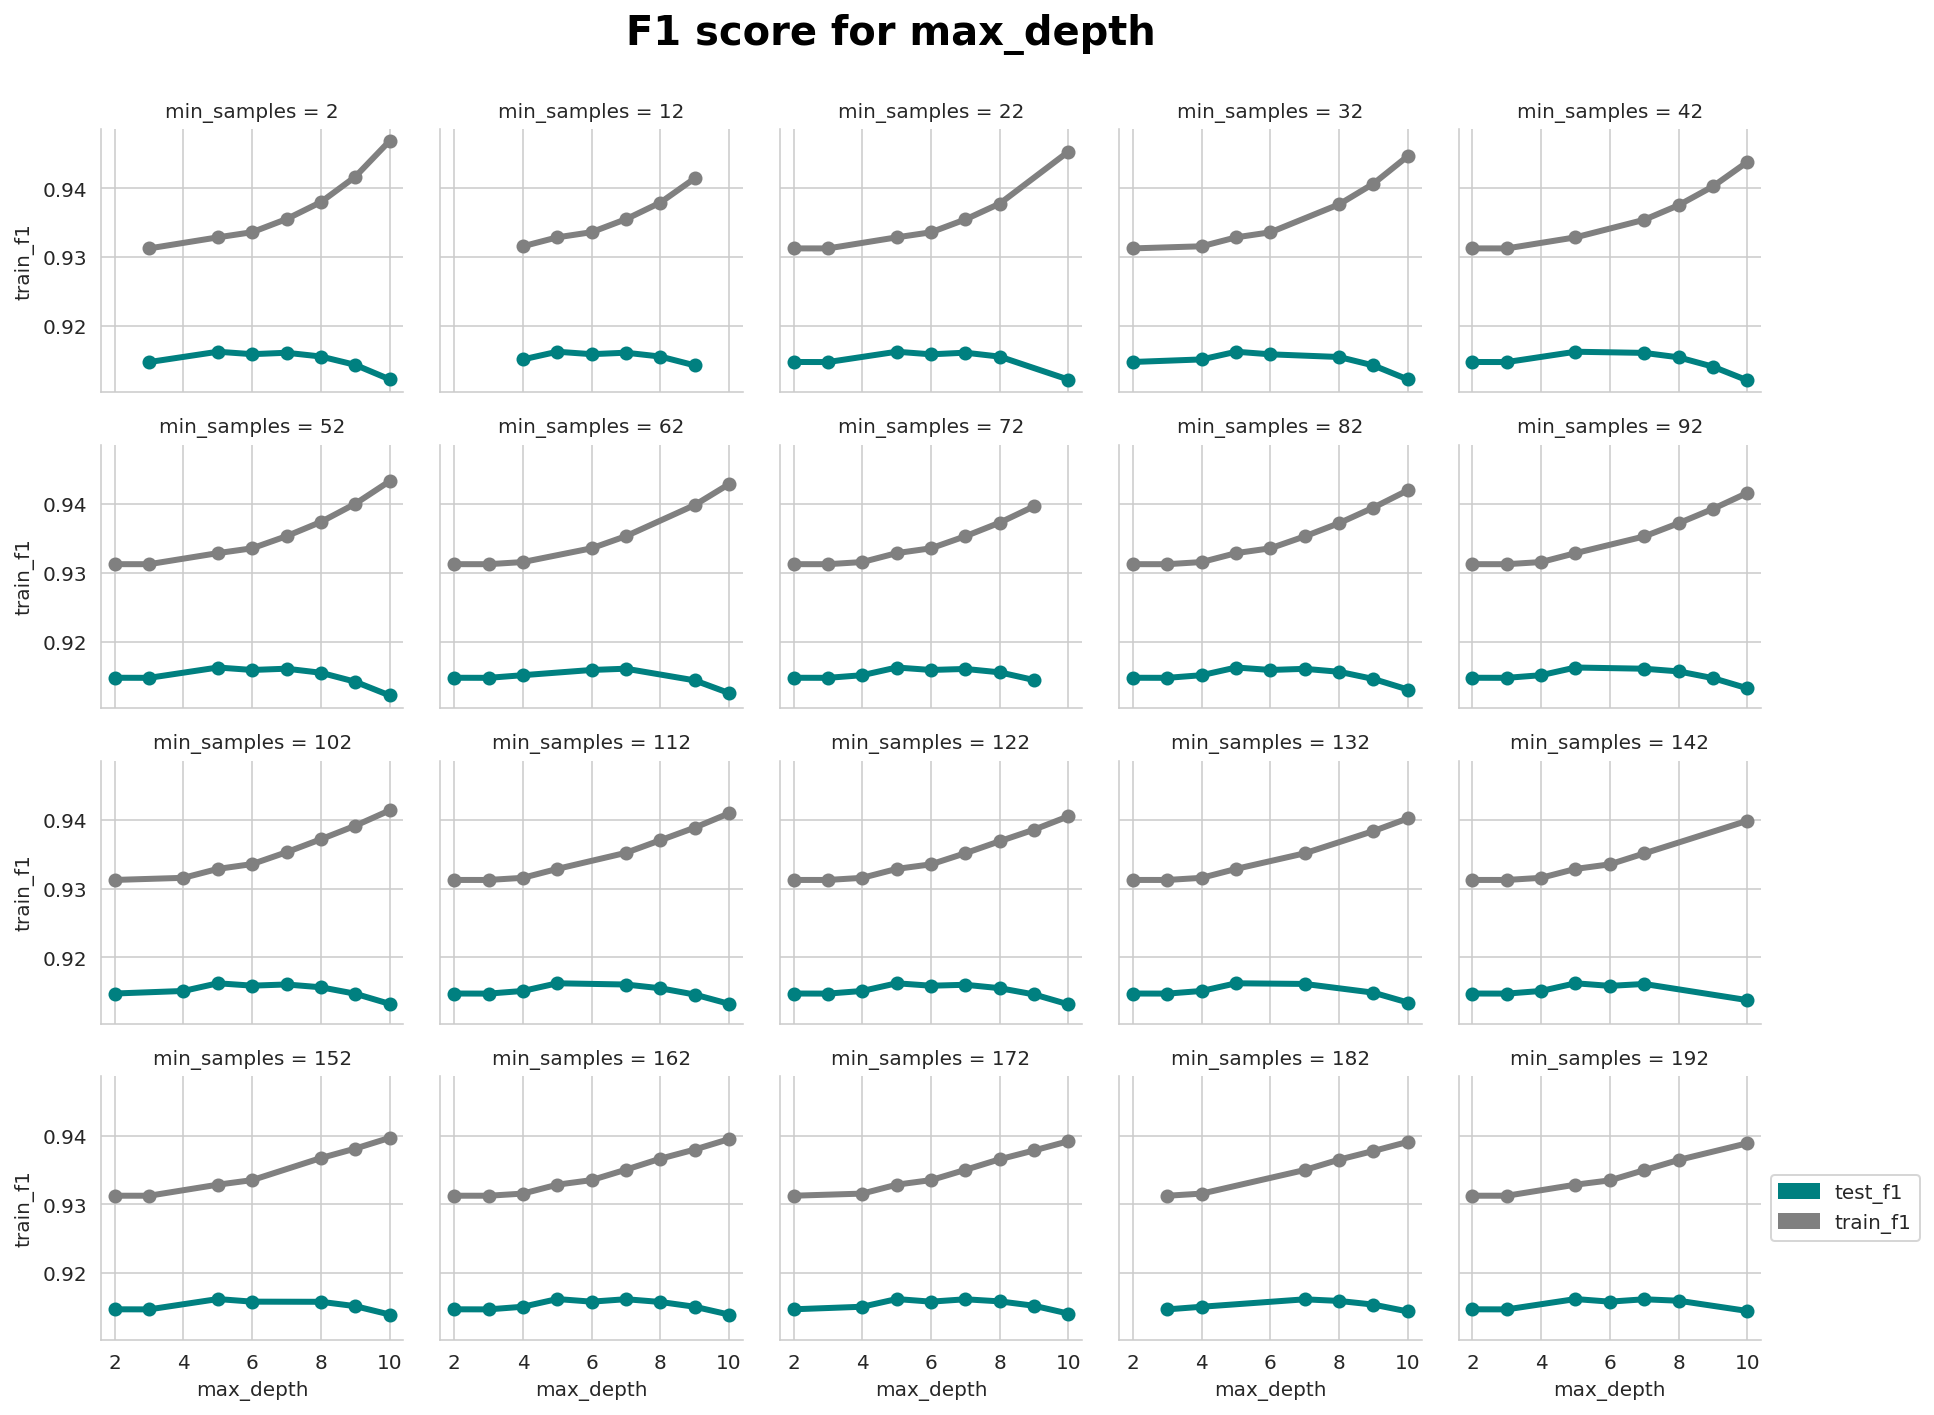

In [135]:
g = sns.FacetGrid(grid_res, col="min_samples", col_wrap=5, height=2.5)
g = g.map(plt.plot, "max_depth", "test_f1", marker="o", color='teal', linewidth=3)
g = g.map(plt.plot, "max_depth", "train_f1", marker="o", color='grey', linewidth=3)
# legend_labels  = ['test_f1', 'train_f1']
# plt.legend(handles=legend_patches)
legend_patches = [matplotlib.patches.Patch(color='teal', label='test_f1'),
                 matplotlib.patches.Patch(color='grey', label='train_f1')]
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1,0.5))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('F1 score for max_depth', size=20, weight='bold', color='black');

### RandomizedSearch 2

In [136]:
estimator = grid.best_estimator_

In [137]:
params = {
    'min_samples_leaf': [*range(2, 11)],
    'splitter': ['random', 'best']
}

In [138]:
grid2 = RandomizedSearchCV(estimator=estimator,
                    param_distributions=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_iter=10,
                    n_jobs=8)

In [ ]:
grid2.fit(features, labels)

In [140]:
grid_res2 = get_summary_randomized(grid2)
grid_res2.sort_values('test_f1', ascending=False).head()

,train_recall,test_recall,train_precision,test_precision,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,score_time,min_samples_leaf,splitter
1,0.9931,0.991009,0.879642,0.852109,0.875552,0.847406,0.932882,0.916243,12.576650,0.077241,8,best
4,0.9931,0.991009,0.879642,0.852109,0.875552,0.847406,0.932882,0.916243,12.329660,0.072500,2,best
5,0.9931,0.991009,0.879642,0.852109,0.875552,0.847406,0.932882,0.916243,12.172849,0.078588,10,best
7,0.9931,0.991009,0.879642,0.852109,0.875552,0.847406,0.932882,0.916243,11.861377,0.090395,3,best
9,0.9931,0.991009,0.879642,0.852109,0.875552,0.847406,0.932882,0.916243,11.266264,0.069265,7,best


In [141]:
grid2.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=142,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

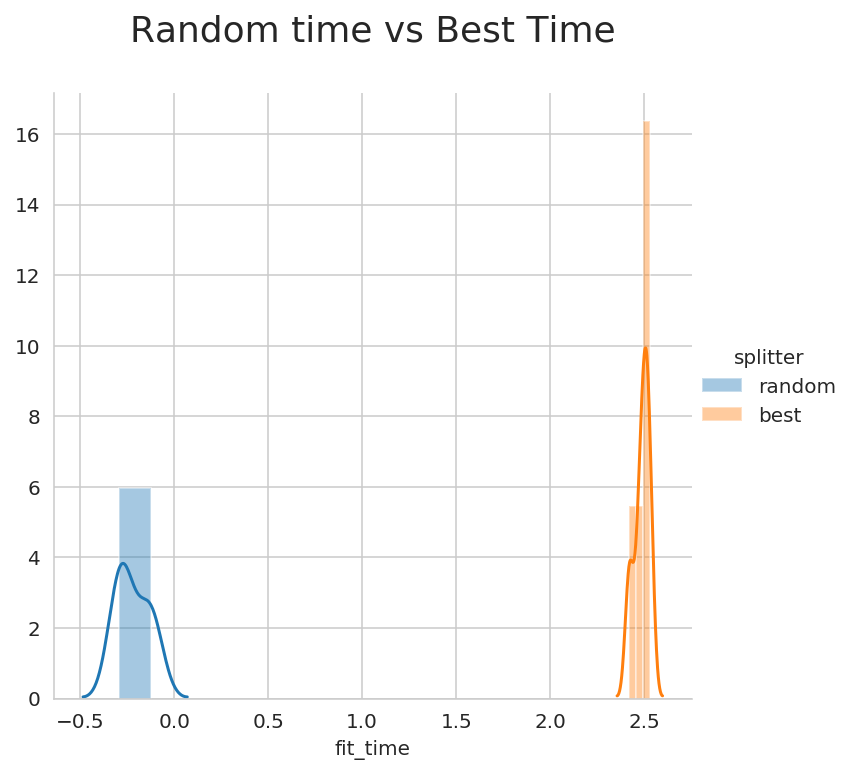

In [142]:
grid_res2['fit_time'] = np.log(grid_res2['fit_time'])
sns.FacetGrid(grid_res2, hue='splitter', height=5).map(sns.distplot, 'fit_time').add_legend();
plt.title('Random time vs Best Time\n', fontsize=18);

### Saving the best estimator

In [143]:
joblib.dump(grid2.best_estimator_, 'TFIDF_W2V_best.model')

['TFIDF_W2V_best.model']

## Reporting the F1 score on the test data

In [11]:
clf_bow = joblib.load('bow_best.model')
clf_avg_w2v = joblib.load('AVG_W2V_best.model')
clf_tfidf_w2v = joblib.load('TFIDF_W2V_best.model')

In [14]:
Dtrain = pd.read_csv('../Amazon_Review_commons/Dtrain.csv')
Dtest = pd.read_csv('../Amazon_Review_commons/Dtest.csv')

In [13]:
Dtrain_bow = sparse.load_npz('../Amazon_Review_commons/BOW_train.npz')
Dtest_bow = sparse.load_npz('../Amazon_Review_commons/BOW_test.npz')

In [15]:
yTrain_bow = Dtrain.Polarity
yTest_bow = Dtest.Polarity

In [16]:
xTest_bow = Dtest_bow
actuals_bow = yTest_bow.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_avg_w2v = Dtest_avg_w2v
actuals_avg_w2v = yTest_avg_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_tfidf_w2v = Dtest_tfidf_w2v
actuals_tfidf_w2v = yTest_tfidf_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [17]:
preds_bow = clf_bow.predict(xTest_bow)
preds_avg_w2v = clf_avg_w2v.predict(xTest_avg_w2v)
preds_tfidf_w2v = clf_tfidf_w2v.predict(xTest_tfidf_w2v)

In [22]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [23]:
acs_bow = accuracy_score(actuals_bow, preds_bow)
acs_avg_w2v = accuracy_score(actuals_avg_w2v, preds_avg_w2v)
acs_tfidf_w2v = accuracy_score(actuals_tfidf_w2v, preds_tfidf_w2v)

pre_bow = precision_score(actuals_bow, preds_bow)
pre_avg_w2v = precision_score(actuals_avg_w2v, preds_avg_w2v)
pre_tfidf_w2v = precision_score(actuals_tfidf_w2v, preds_tfidf_w2v)

rec_bow = recall_score(actuals_bow, preds_bow)
rec_avg_w2v = recall_score(actuals_avg_w2v, preds_avg_w2v)
rec_tfidf_w2v = recall_score(actuals_tfidf_w2v, preds_tfidf_w2v)

f1_bow = f1_score(actuals_bow, preds_bow)
f1_avg_w2v = f1_score(actuals_avg_w2v, preds_avg_w2v)
f1_tfidf_w2v = f1_score(actuals_tfidf_w2v, preds_tfidf_w2v)



from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorization', 'Accuracy', 'Precision', 'Recall', 'F1']
x.add_row(['BOW', acs_bow, pre_bow, rec_bow, f1_bow])
x.add_row(['Avg. W2V', acs_avg_w2v, pre_avg_w2v, rec_avg_w2v, f1_avg_w2v])
x.add_row(['TFIDF W2V', acs_tfidf_w2v, pre_tfidf_w2v, rec_tfidf_w2v, f1_tfidf_w2v])
print(x)

+---------------+--------------------+--------------------+--------------------+--------------------+
| Vectorization |      Accuracy      |     Precision      |       Recall       |         F1         |
+---------------+--------------------+--------------------+--------------------+--------------------+
|      BOW      | 0.8432568017869567 | 0.8456667423898228 | 0.9909383318544809 | 0.9125571988887073 |
|    Avg. W2V   | 0.8411604233036728 | 0.8618030016896929 | 0.9617649995008486 | 0.9090442066857829 |
|   TFIDF W2V   | 0.8306419129224798 | 0.8399517967111693 | 0.981886348762659  | 0.9053902014933006 |
+---------------+--------------------+--------------------+--------------------+--------------------+


In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
cm_avg_w2v = pd.DataFrame(confusion_matrix(actuals_avg_w2v, preds_avg_w2v),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_tfidf_w2v = pd.DataFrame(confusion_matrix(actuals_tfidf_w2v, preds_tfidf_w2v),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_bow = pd.DataFrame(confusion_matrix(actuals_bow, preds_bow),
             columns=['negative', 'positive'], index=['negative', 'positive'])

### Avg. W2V

In [26]:
cm_avg_w2v

,negative,positive
negative,5179,13904
positive,3447,86706


### TFIDF W2v

In [27]:
cm_tfidf_w2v

,negative,positive
negative,2216,16867
positive,1633,88520


### BOW

In [30]:
### WOW what a great performnce on False Negative..literally half the score
cm_bow

,negative,positive
negative,2771,16305
positive,817,89343
